In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict


In [ ]:

!unzip "/content/drive/MyDrive/oa/archive.zip" -d "/content/drive/MyDrive/oa/kneeoa"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/oa/kneeoa/train/0/9684605R.png  
  inflating: /content/drive/MyDrive/oa/kneeoa/train/0/9685238L.png  
  inflating: /content/drive/MyDrive/oa/kneeoa/train/0/9685238R.png  
  inflating: /content/drive/MyDrive/oa/kneeoa/train/0/9686617L.png  
  inflating: /content/drive/MyDrive/oa/kneeoa/train/0/9686617R.png  
  inflating: /content/drive/MyDrive/oa/kneeoa/train/0/9686777R.png  
  inflating: /content/drive/MyDrive/oa/kneeoa/train/0/9686834L.png  
  inflating: /content/drive/MyDrive/oa/kneeoa/train/0/9686834R.png  
  inflating: /content/drive/MyDrive/oa/kneeoa/train/0/9686908L.png  
  inflating: /content/drive/MyDrive/oa/kneeoa/train/0/9686908R.png  
  inflating: /content/drive/MyDrive/oa/kneeoa/train/0/9687273L.png  
  inflating: /content/drive/MyDrive/oa/kneeoa/train/0/9689906R.png  
  inflating: /content/drive/MyDrive/oa/kneeoa/train/0/9690910L.png  
  inflating: /content/drive/MyDrive/oa/kneeoa/train/

In [3]:
splits = ['train', 'test', 'val', 'auto-test']  # Adjust as per your dataset structure
severity_classes = ['0', '1', '2', '3', '4']

In [ ]:
import os
import shutil
from tqdm import tqdm

original_dataset_path = '/content/drive/MyDrive/oa/kneeoa'  # Original dataset path
new_dataset_path = '/content/drive/MyDrive/oa/ortho/'  # New writable dataset path
severity_classes = ['0', '1', '2', '3', '4']  # List of severity classes

def copy_images(src_folder, dest_folder):
    for severity in severity_classes:
        src_path = os.path.join(original_dataset_path, src_folder, severity)
        dest_path = os.path.join(new_dataset_path, dest_folder, severity)

        if not os.path.exists(dest_path):
            os.makedirs(dest_path)

        # Get a list of image files in the source folder
        image_files = [file for file in os.listdir(src_path) if file.lower().endswith('.png')]

        # Create a tqdm progress bar for image copying
        with tqdm(total=len(image_files), desc=f'Copying from {src_folder} to {dest_folder} (Severity {severity})') as pbar:
            for file in image_files:
                src_file = os.path.join(src_path, file)
                dest_file = os.path.join(dest_path, file)

                # Copy the image file
                shutil.copy(src_file, dest_file)

                # Update the progress bar
                pbar.update(1)

# Copy images from the original datasets to the new 'all' directory
copy_images('train', 'all')
copy_images('test', 'all')
copy_images('val', 'all')
copy_images('auto_test', 'all')

print("Images copied to the new 'all' directory.")


Copying from auto_test to all (Severity 4): 100%|██████████| 44/44 [00:00<00:00, 154.25it/s]

Images copied to the new 'all' directory.


In [4]:
def analyze_dataset(base_path):
    image_dimensions = defaultdict(list)
    image_formats = defaultdict(int)
    for severity in severity_classes:
        folder_path = os.path.join(base_path, severity)
        if os.path.exists(folder_path):
            image_files = os.listdir(folder_path)
            print(f"  Severity {severity}: {len(image_files)} images")

            for image_file in image_files:
                image_path = os.path.join(folder_path, image_file)
                with Image.open(image_path) as img:
                    image_dimensions[severity].append(img.size)
                    image_formats[img.format] += 1

    # Image formats
    print("Image Formats in the Dataset:", image_formats)



In [ ]:
analyze_dataset("/content/drive/MyDrive/oa/ortho/all")

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image

num_samples = 5  # Number of samples per class

def display_sample_images(base_path):
    fig, axes = plt.subplots(len(severity_classes), num_samples, figsize=(15, 10))
    fig.suptitle('Sample Images with Severity Labels')

    for i, severity in enumerate(severity_classes):
        folder_path = os.path.join(base_path, severity)  # Using the first split (e.g., 'train') for samples
        if os.path.exists(folder_path) and os.listdir(folder_path):
            sample_image_files = os.listdir(folder_path)[:num_samples]  # First five images
            for j, image_file in enumerate(sample_image_files):
                image_path = os.path.join(folder_path, image_file)
                image = Image.open(image_path)
                axes[i, j].imshow(image, cmap='gray')
                axes[i, j].axis('off')
                # Label each image with its severity
                axes[i, j].set_title(f'Severity {severity}', fontsize=8, pad=3)

    plt.tight_layout()
    plt.show()

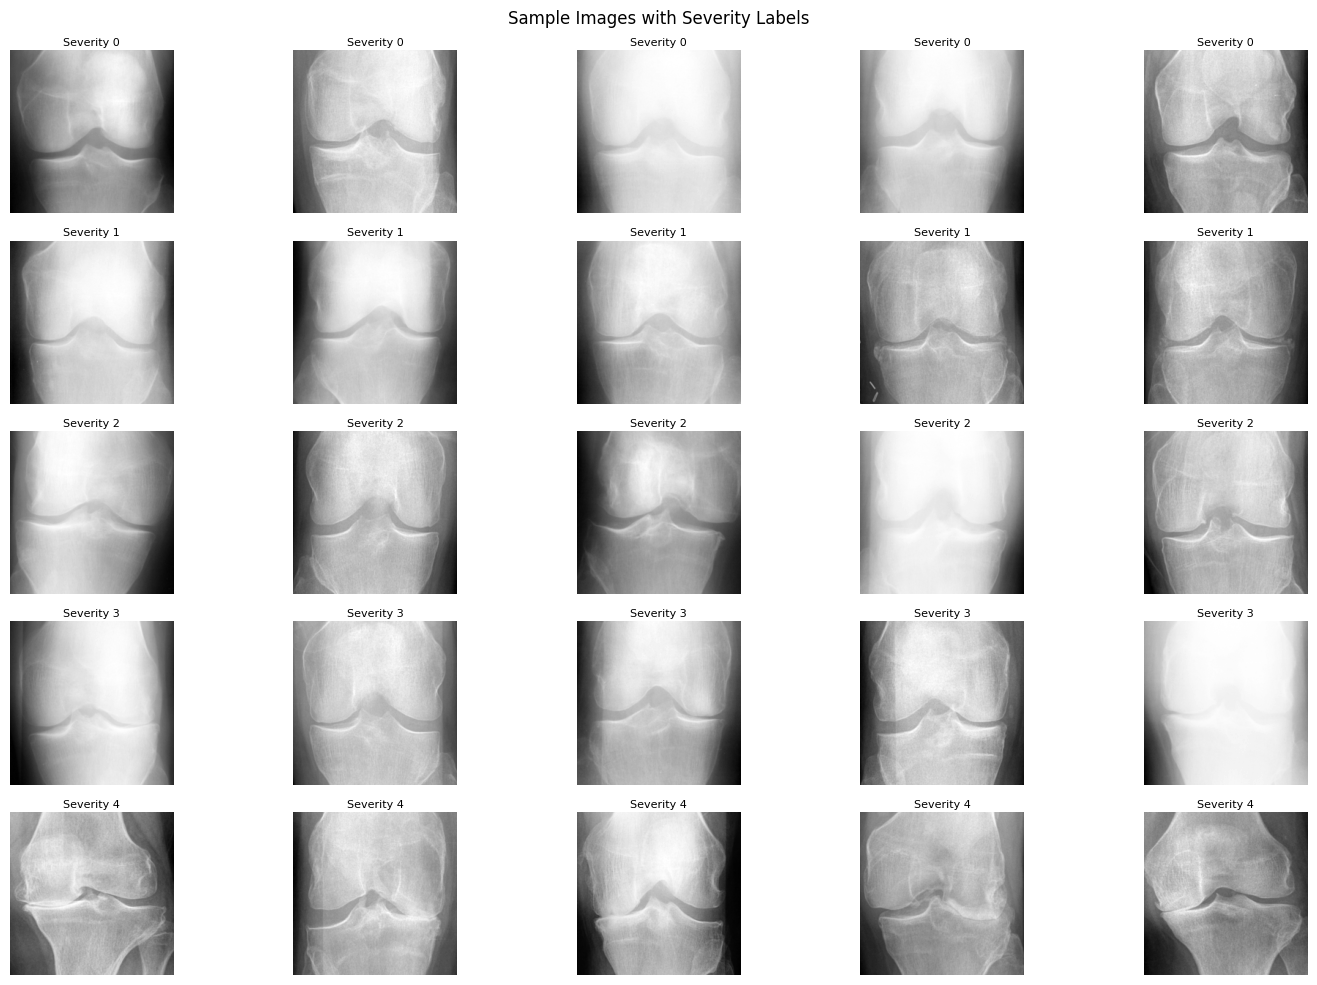

In [ ]:


display_sample_images("/content/drive/MyDrive/oa/ortho/all")


In [ ]:
import cv2
import os
from tqdm import tqdm

def denoise_images(source_folder, target_folder):
    # Create target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Iterate over each severity folder
    for severity in range(5):
        severity_folder = os.path.join(source_folder, str(severity))
        target_severity_folder = os.path.join(target_folder, str(severity))

        # Create target severity folder if it doesn't exist
        if not os.path.exists(target_severity_folder):
            os.makedirs(target_severity_folder)

        # Get a list of image files in the severity folder
        image_files = [filename for filename in os.listdir(severity_folder) if filename.lower().endswith('.png')]

        # Create a tqdm progress bar for image processing
        with tqdm(total=len(image_files), desc=f'Severity {severity}') as pbar:
            # Iterate over each image in the severity folder
            for filename in image_files:
                file_path = os.path.join(severity_folder, filename)

                # Read the image in grayscale
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

                # Apply denoising
                denoised_image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

                # Save the denoised image
                cv2.imwrite(os.path.join(target_severity_folder, filename), denoised_image)

                # Update the progress bar
                pbar.update(1)

# Use the function
source_folder = '/content/drive/MyDrive/oa/ortho/all'
target_folder = '/content/drive/MyDrive/oa/denoised'
denoise_images(source_folder, target_folder)


Severity 4: 100%|██████████| 295/295 [00:27<00:00, 10.83it/s]


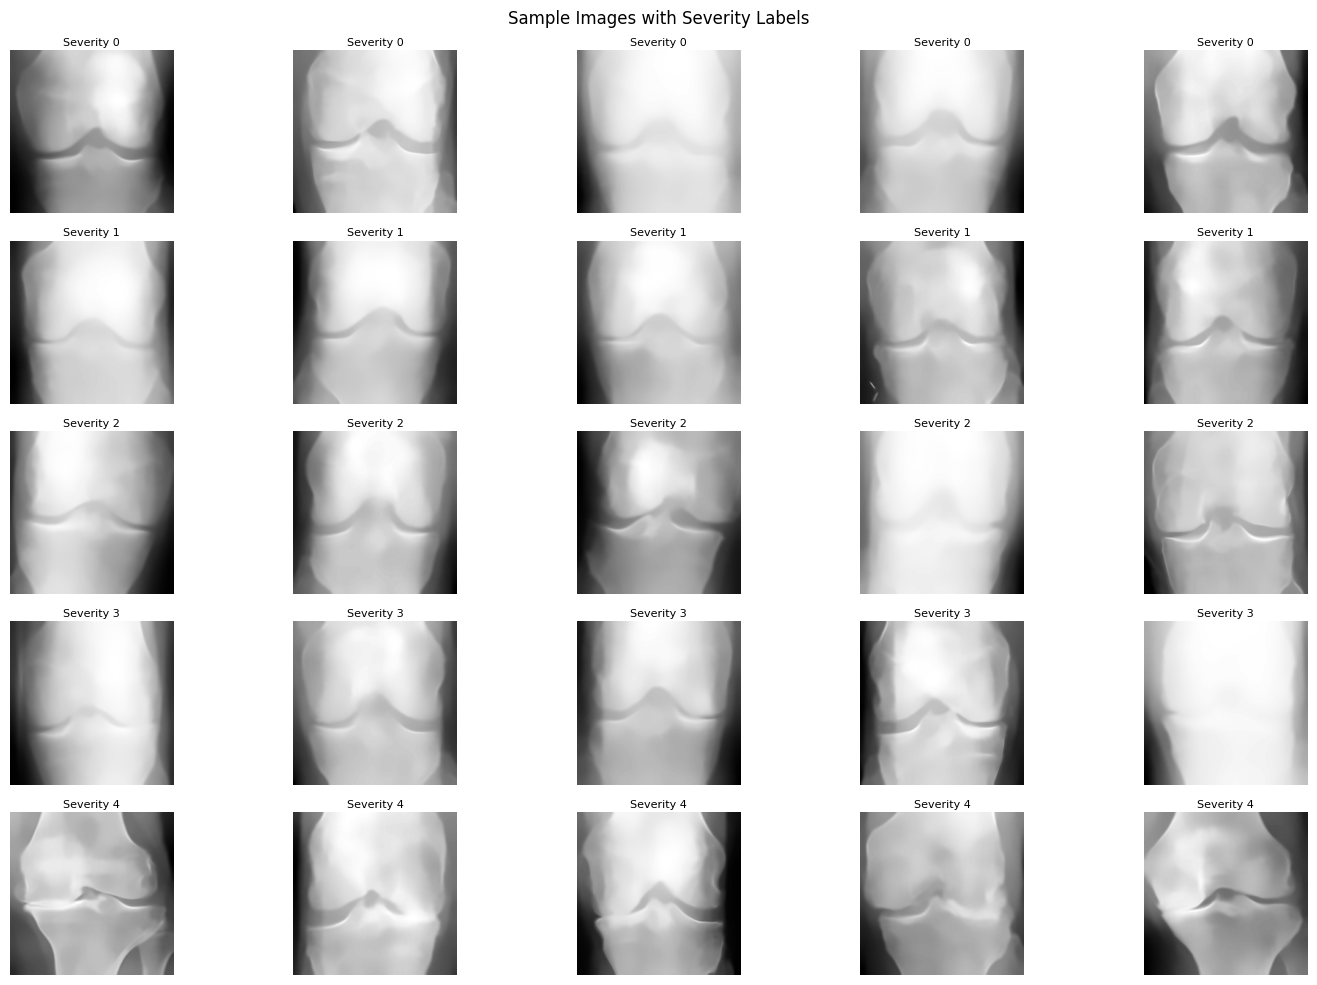

In [ ]:
display_sample_images("/content/drive/MyDrive/oa/denoised")


In [ ]:
import cv2
import os
from tqdm import tqdm

def apply_clahe(source_folder, target_folder):
    # Create target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Initialize CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Iterate over each severity folder
    for severity in range(5):
        severity_folder = os.path.join(source_folder, str(severity))
        target_severity_folder = os.path.join(target_folder, str(severity))

        # Create target severity folder if it doesn't exist
        if not os.path.exists(target_severity_folder):
            os.makedirs(target_severity_folder)

        # List of files in the severity folder
        files = [f for f in os.listdir(severity_folder) if f.lower().endswith('.png')]

        # Progress bar
        pbar = tqdm(total=len(files), desc=f"Processing Severity {severity}")

        # Iterate over each image in the severity folder
        for filename in files:
            file_path = os.path.join(severity_folder, filename)

            # Read the image in grayscale
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            # Apply CLAHE
            clahe_image = clahe.apply(image)

            # Save the CLAHE image
            cv2.imwrite(os.path.join(target_severity_folder, filename), clahe_image)

            # Update progress bar
            pbar.update(1)

        pbar.close()

# Use the function
source_folder = '/content/drive/MyDrive/oa/denoised'  # Path to your denoised dataset
target_folder = '/content/drive/MyDrive/oa/clahe'     # Path to save CLAHE processed images
apply_clahe(source_folder, target_folder)


Processing Severity 4: 100%|██████████| 295/295 [00:03<00:00, 97.17it/s] 


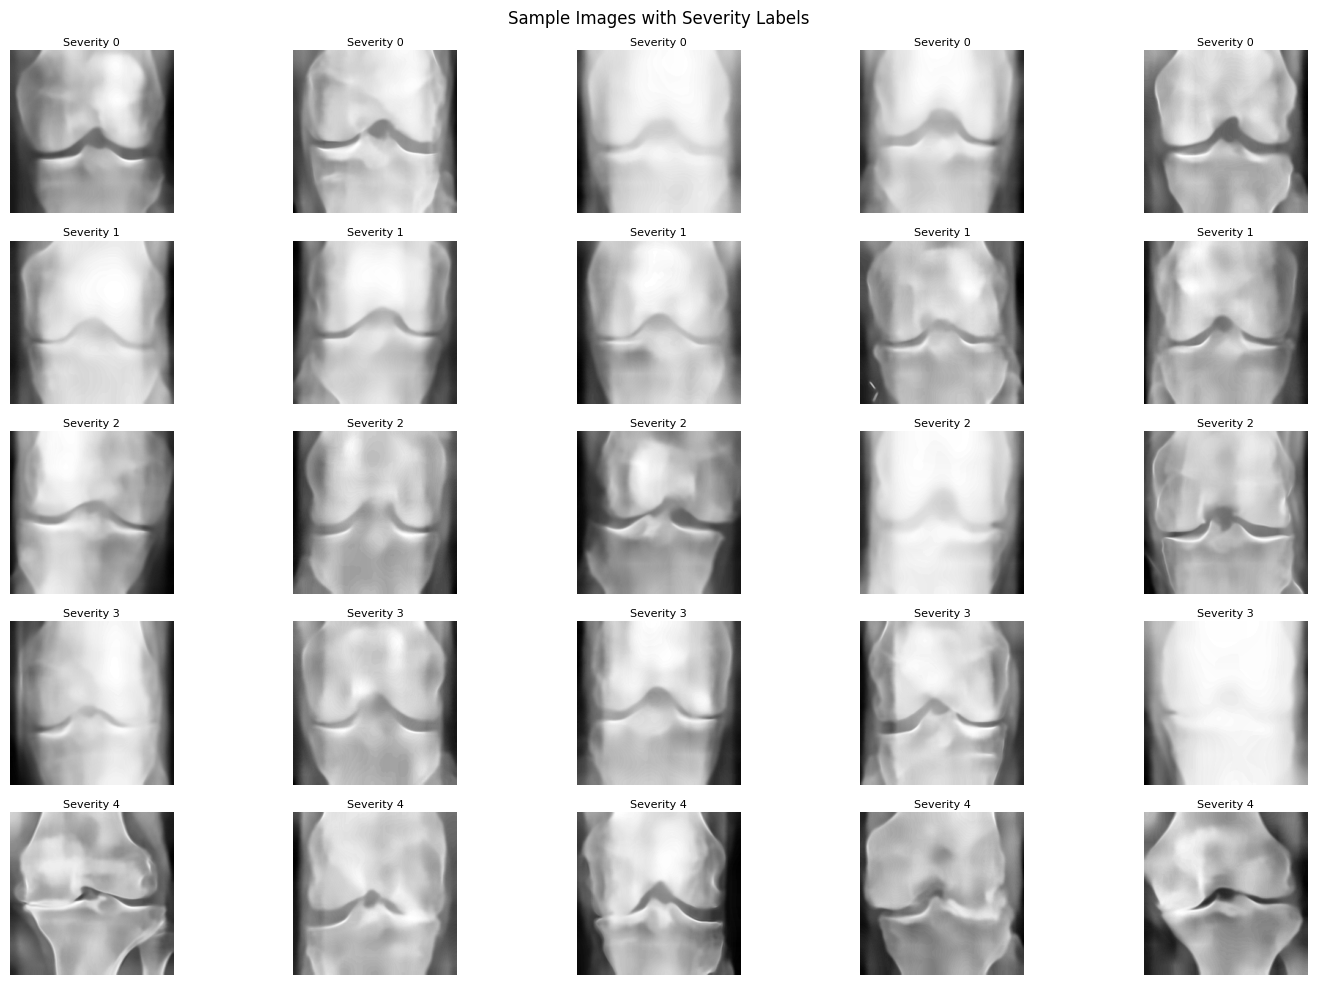

In [ ]:
display_sample_images("/content/drive/MyDrive/oa/clahe")


In [ ]:
import cv2
import os
from tqdm import tqdm
import numpy as np

def apply_clahe_and_normalize(source_folder, target_folder):
    # Create target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Initialize CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Iterate over each severity folder
    for severity in range(5):
        severity_folder = os.path.join(source_folder, str(severity))
        target_severity_folder = os.path.join(target_folder, str(severity))

        # Create target severity folder if it doesn't exist
        if not os.path.exists(target_severity_folder):
            os.makedirs(target_severity_folder)

        # List of files in the severity folder
        files = [f for f in os.listdir(severity_folder) if f.lower().endswith('.png')]

        # Progress bar
        pbar = tqdm(total=len(files), desc=f"Processing Severity {severity}")

        # Iterate over each image in the severity folder
        for filename in files:
            file_path = os.path.join(severity_folder, filename)

            # Read the image in grayscale
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            # Apply CLAHE
            clahe_image = clahe.apply(image)

            # Normalize the image
            normalized_image = clahe_image.astype('float32') / 255.0

            # Save the normalized image
            cv2.imwrite(os.path.join(target_severity_folder, filename), normalized_image * 255)

            # Update progress bar
            pbar.update(1)

        pbar.close()

# Use the function
source_folder = '/content/drive/MyDrive/oa/clahe'  # Path to your CLAHE processed dataset
target_folder = '/content/drive/MyDrive/oa/normalized'  # Path to save normalized images
apply_clahe_and_normalize(source_folder, target_folder)


Processing Severity 4: 100%|██████████| 295/295 [00:03<00:00, 96.43it/s] 


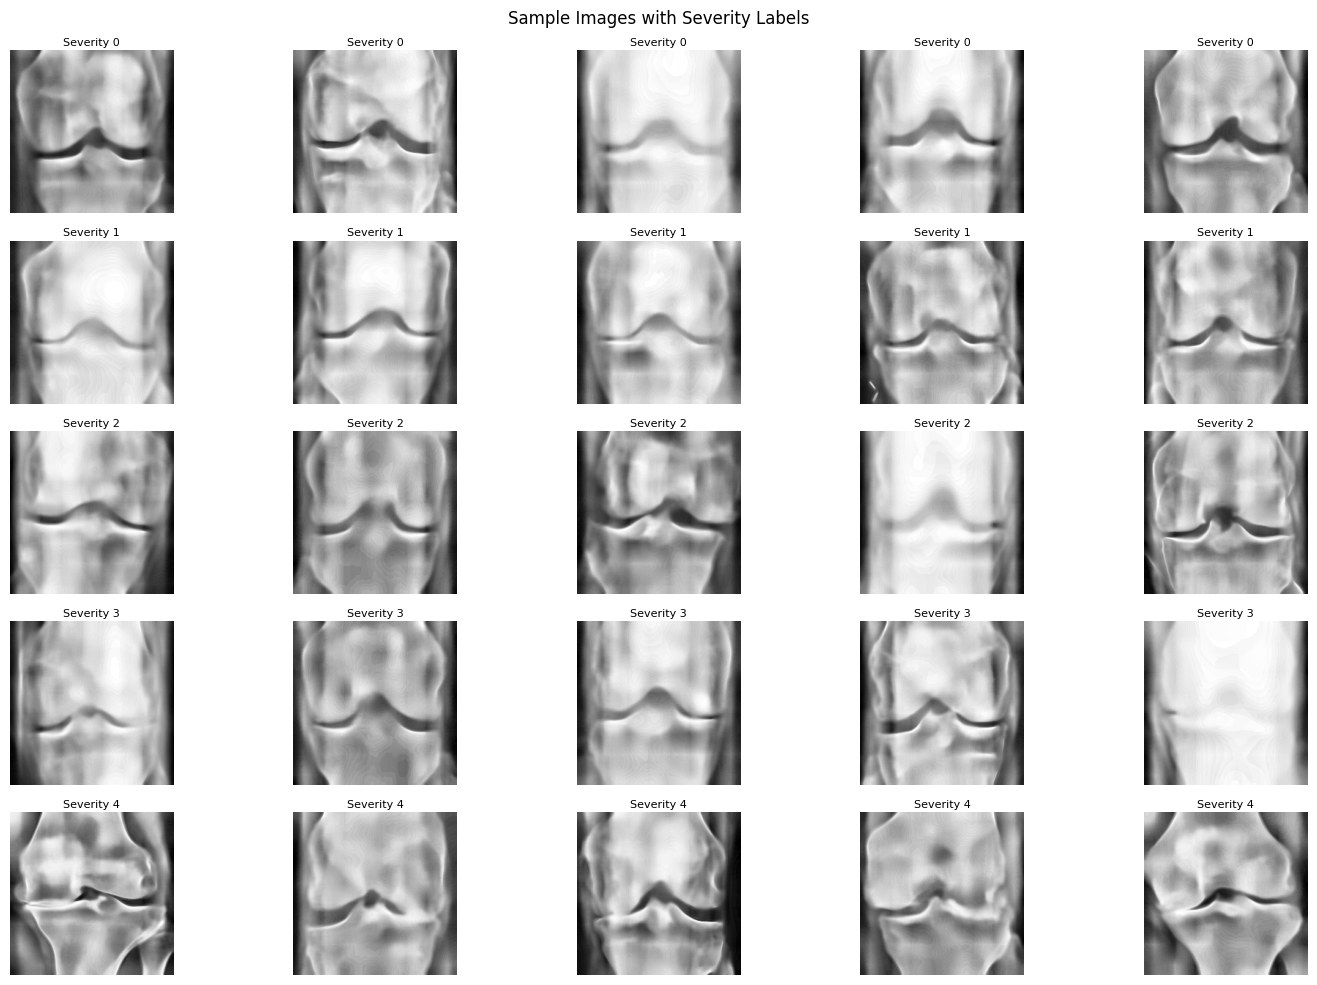

In [ ]:
display_sample_images("/content/drive/MyDrive/oa/normalized")

In [ ]:
import cv2
import os
import numpy as np
from albumentations import Compose, Flip, RandomRotate90, Affine
from tqdm import tqdm
import random

def oversample_and_augment(source_folder, target_folder, augmenter, target_count):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    for severity in range(5):
        severity_folder = os.path.join(source_folder, str(severity))
        target_severity_folder = os.path.join(target_folder, str(severity))

        if not os.path.exists(target_severity_folder):
            os.makedirs(target_severity_folder)

        files = [f for f in os.listdir(severity_folder) if f.lower().endswith('.png')]
        current_count = len(files)
        augmentation_needed = target_count - current_count

        # Copy existing images
        for filename in files:
            shutil.copyfile(os.path.join(severity_folder, filename), os.path.join(target_severity_folder, filename))

        # Augmentation for oversampling
        if augmentation_needed > 0:
            pbar = tqdm(total=augmentation_needed, desc=f"Augmenting Severity {severity}")

            while augmentation_needed > 0:
                for filename in files:
                    if augmentation_needed <= 0:
                        break

                    file_path = os.path.join(severity_folder, filename)

                    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    image_aug = augmenter(image=image)['image']

                    new_filename = f"aug_{augmentation_needed}_{filename}"
                    cv2.imwrite(os.path.join(target_severity_folder, new_filename), image_aug)

                    augmentation_needed -= 1
                    pbar.update(1)

            pbar.close()

# Define your augmentation pipeline here
augmenter = Compose([
    Flip(p=0.5),
    RandomRotate90(p=0.5),
    Affine(rotate=(-10, 10), scale=(0.8, 1.2), p=0.5)
])

source_folder = '/content/drive/MyDrive/oa/normalized'  # Path to your normalized dataset
target_folder = '/content/drive/MyDrive/oa/oversampled'    # Path to save oversampled and augmented dataset
target_count = 4000  # target count per class

oversample_and_augment(source_folder, target_folder, augmenter, target_count)


Augmenting Severity 4: 100%|██████████| 3705/3705 [00:40<00:00, 90.61it/s]


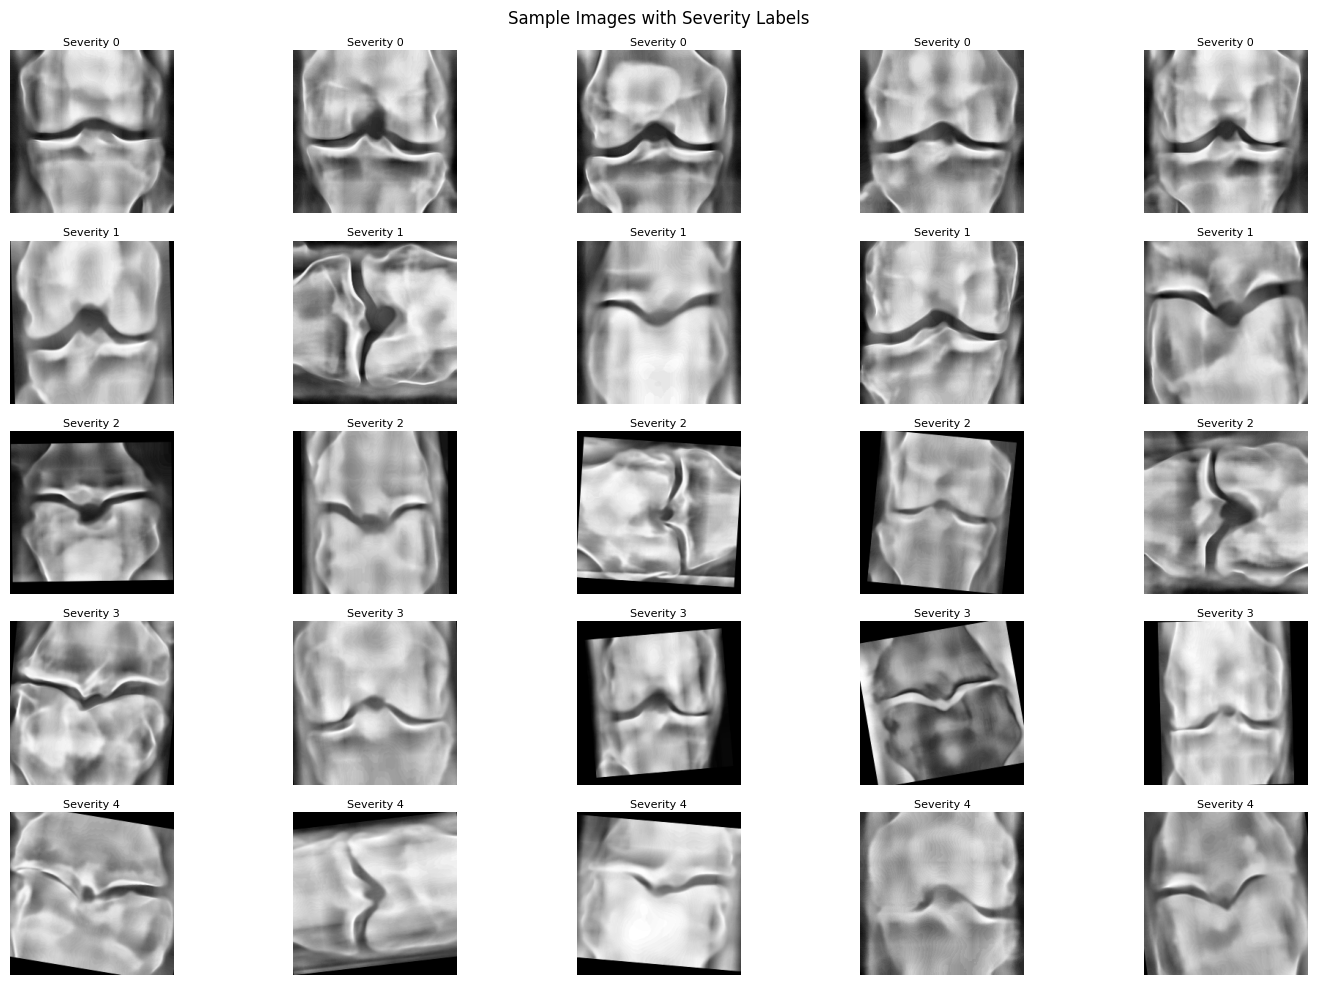

In [7]:
display_sample_images("/content/drive/MyDrive/oa/oversampled/oversampled")

In [ ]:
original_dataset_path = '/content/drive/MyDrive/oa/'  # Original dataset path
new_dataset_path = '/content/drive/MyDrive/oa/'  # New writable dataset path
copy_images('normalized', 'oversampled')

Copying from normalized to oversampled (Severity 0): 100%|██████████| 3857/3857 [00:26<00:00, 145.18it/s]
Copying from normalized to oversampled (Severity 1): 100%|██████████| 1770/1770 [00:12<00:00, 140.35it/s]
Copying from normalized to oversampled (Severity 2): 100%|██████████| 2578/2578 [00:18<00:00, 141.19it/s]
Copying from normalized to oversampled (Severity 3): 100%|██████████| 1286/1286 [00:09<00:00, 141.82it/s]
Copying from normalized to oversampled (Severity 4): 100%|██████████| 295/295 [00:02<00:00, 143.12it/s]


In [ ]:
analyze_dataset("/content/drive/MyDrive/oa/oversampled")

  Severity 0: 4000 images
  Severity 1: 4000 images
  Severity 2: 4000 images
  Severity 3: 4000 images
  Severity 4: 4000 images
Image Formats in the Dataset: defaultdict(<class 'int'>, {'PNG': 20000})


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [5]:
# Define data augmentation and load the data
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Adjust the validation split percentage as needed
)

# Load the balanced dataset
balanced_directory = '/content/drive/MyDrive/oa/oversampled/oversampled'
batch_size = 32

# Create generators for both training and validation
train_generator = datagen.flow_from_directory(
    balanced_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,  # Shuffle the data to ensure randomness
    subset='training'  # Specify 'training' to get the training split
)

val_generator = datagen.flow_from_directory(
    balanced_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'  # Specify 'validation' to get the validation split
)


Found 16000 images belonging to 5 classes.
Found 4000 images belonging to 5 classes.


In [6]:
# Build the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)  # 5 classes for severity levels

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)



58889256/58889256 [==============================] - 0s 0us/step


In [7]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=5  # Adjust the number of epochs as needed
)

Epoch 1/5
500/500 [==============================] - 5732s 11s/step - loss: 1.4890 - accuracy: 0.3217 - val_loss: 1.2810 - val_accuracy: 0.4137
Epoch 2/5
500/500 [==============================] - 378s 755ms/step - loss: 1.2624 - accuracy: 0.4370 - val_loss: 1.0704 - val_accuracy: 0.4935
Epoch 3/5
500/500 [==============================] - 377s 754ms/step - loss: 1.0552 - accuracy: 0.5440 - val_loss: 0.9569 - val_accuracy: 0.5610
Epoch 4/5
500/500 [==============================] - 385s 769ms/step - loss: 0.9361 - accuracy: 0.6012 - val_loss: 1.0169 - val_accuracy: 0.5310
Epoch 5/5
500/500 [==============================] - 404s 807ms/step - loss: 0.8771 - accuracy: 0.6292 - val_loss: 0.9098 - val_accuracy: 0.5993


In [9]:
model_save_path = 'vgg16_model_15_02_v1.h5'

# Save the model
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to vgg16_model_15_02_v1.h5


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=5  # Adjust the number of epochs as needed
)

Epoch 1/5
500/500 [==============================] - ETA: 0s - loss: 0.8297 - accuracy: 0.6484

In [ ]:
# Define the path where you want to save the model
model_save_path = 'vgg16_model_15_02_v2.h5'

# Save the model
model.save(model_save_path)

print(f"Model saved to {model_save_path}")
